In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy
from sklearn.model_selection import train_test_split

import torchvision

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.FashionMNIST(root="fmnist", download=True, train=True, transform=transform)
test_data = torchvision.datasets.FashionMNIST(root="fmnist", download=True, train=False, transform=transform)

In [8]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=len(test_data))

In [17]:
train_data.data[0].shape

torch.Size([28, 28])

In [27]:
class Model(nn.Module):
    def __init__ (self, printtoggle=False):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        # size of output image = np.floor( (28+2*1-3)/1 )+1 = 28/2 = 14 (/2 b/c maxpool)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # size of output image = np.floor( (14+2*1-3)/1 )+1 = 14/2 = 7 (/2 b/c maxpool)

        # computing number of units in fully connected layer (output of conv2)
        # it should be number of channels X height of image X width of image
        expectSize = 128*7*7

        self.fc1 = nn.Linear(expectSize, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10) # 10 because the images represent number from 0 to 9

        # toggle for printing out tensor sizes during forward prop
        self.print = printtoggle

    def forward(self, x):
        print(f'Input: {x.shape}') if self.print else None

        # convolution -> max pooling -> relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 2 is size of the pooling region or spatial extent or window size
        print(f'Layer conv1/pool1: {x.shape}') if self.print else None

        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        print(f'Layer conv2/pool2: {x.shape}') if self.print else None

        # reshape for FC layer
        nUnits = x.shape.numel()/x.shape[0]
        # here x.shape = (batch_size, channels, height, width)
        # and x.shape.numel() gives the product of batch_size, channels, height, width, hence it returns the total number of elements in tensor x
        # x.shape[0] = batch_size
        # so, nUnits is number of elements per batch or sample. This will be equal to expectSize
        if self.print: print(f'nUnits: {nUnits}')

        x = x.view(-1, int(nUnits))
        # here we are flattening the elements. view is used to reshape the tensor.
        # -1 is used when we don't know how many rows are required to fit the number elements specified in the column parameter.
        # if -1 is used at column parameter, like x.view(int(nUnits), -1), then it calculates the required number of rows.
        if self.print: print(f'Vectorize: {x.shape}')

        x = F.relu(self.fc1(x))
        if self.print: print(f'Layer fc1: {x.shape}')
        x = F.relu(self.fc2(x))
        if self.print: print(f'Layer fc2: {x.shape}')
        x = self.out(x)
        if self.print: print(f'Layer out: {x.shape}')

        return x

In [32]:
def getModel(printtoggle=False):
    
    CNN = Model(printtoggle)

    lossFunction = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(CNN.parameters(), lr=0.001)

    return CNN, lossFunction, optimizer

In [33]:
# testing model

CNN, lossFunction, optimizer = getModel(True)

X, y = next(iter(train_loader))
yHat = CNN(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossFunction(yHat, y)
print(' ')
print('Loss:')
print(loss)

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 64, 14, 14])
Layer conv2/pool2: torch.Size([32, 128, 7, 7])
nUnits: 6272.0
Vectorize: torch.Size([32, 6272])
Layer fc1: torch.Size([32, 128])
Layer fc2: torch.Size([32, 64])
Layer out: torch.Size([32, 10])
 
torch.Size([32, 10])
torch.Size([32])
 
Loss:
tensor(2.3301, grad_fn=<NllLossBackward0>)


In [34]:
def trainModel(CNN, lossFunction, optimizer):
    epochs = 10

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    for _ in range(epochs):

        CNN.train()
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            yHat = CNN.forward(x)
            
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        CNN.eval()
        X, Y = next(iter(test_loader))

        with torch.no_grad():
            pred = CNN(X)

        testAcc.append(torch.mean((torch.argmax(pred, axis=1)==Y).float())*100)

        print(' ')
        print('Completed epoch ', _)

    return trainAcc, testAcc, losses, CNN

In [35]:
CNN, lossFunction, optimizer = getModel(False)
trainAcc, testAcc, losses, CNN = trainModel(CNN, lossFunction, optimizer)

 
Completed epoch  0
 
Completed epoch  1
 
Completed epoch  2
 
Completed epoch  3
 
Completed epoch  4
 
Completed epoch  5
 
Completed epoch  6
 
Completed epoch  7
 
Completed epoch  8
 
Completed epoch  9


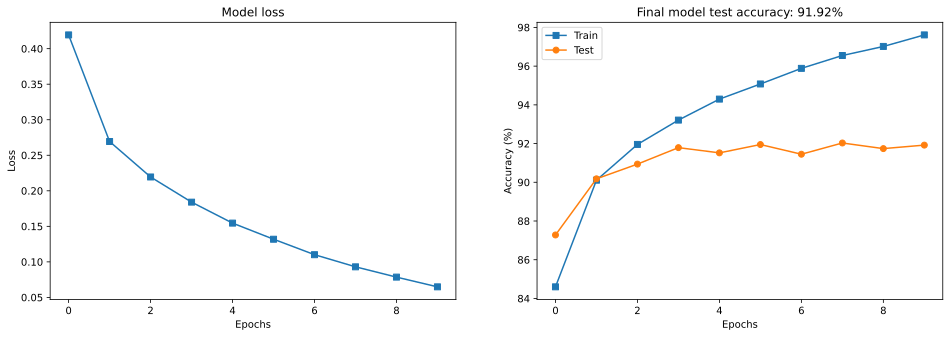

In [36]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()